In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15109 MiB, 15109 MiB


https://github.com/ShivamShrirao/diffusers/tree/main/examples/imagic

## Install Requirements

In [ ]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/imagic/train_imagic.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate==0.12.0 transformers ftfy bitsandbytes gradio

In [4]:
#@title Login to HuggingFace 🤗

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


### Install xformers from precompiled wheel.

In [3]:
%pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/1d31a3ac_various_6/xformers-0.0.14.dev0-cp37-cp37m-linux_x86_64.whl
# These were compiled on Tesla T4, should also work on P100, thanks to https://github.com/metrolobo

# If precompiled wheels don't work, install it with the following command. It will take around 40 minutes to compile.
# %pip install git+https://github.com/facebookresearch/xformers@1d31a3a#egg=xformers

     |████████████████████████████████| 102.9 MB 115 kB/s 


## Settings and run

In [ ]:
#@markdown Name/Path of the initial model.
MODEL_NAME = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

#@markdown Target Text.
TARGET_TEXT = "A bird spreading wings." #@param {type:"string"}

#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = True #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Enter the directory name to save model at.
OUTPUT_DIR = "stable_diffusion_weights/imagic" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")
!mkdir -p $OUTPUT_DIR

#@markdown sks is a rare identifier, feel free to replace it.

In [ ]:
#@markdown Upload your 1 image by running this cell.

import os
from google.colab import files
import shutil

uploaded = files.upload()
for filename in uploaded.keys():
    INPUT_IMAGE = os.path.join(OUTPUT_DIR, filename)
    shutil.move(filename, INPUT_IMAGE)

# Start Training

Add `--gradient_checkpointing` flag to reduce VRAM usage.

remove `--use_8bit_adam` flag for full precision, uses more VRAM

In [ ]:
!accelerate launch train_imagic.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --output_dir=$OUTPUT_DIR \
  --input_image=$INPUT_IMAGE \
  --target_text="{TARGET_TEXT}" \
  --seed=3434554 \
  --resolution=512 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --emb_learning_rate=1e-3 \
  --learning_rate=1e-6 \
  --emb_train_steps=500 \
  --max_train_steps=1000


## Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [8]:
#@markdown Download script
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py

In [ ]:
#@markdown Run conversion.
ckpt_path = OUTPUT_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB), might loose some quality.
fp16 = False #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

## Inference

In [1]:
import os
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

# model_path = OUTPUT_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive
model_path = "../../../models/imagic"

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, torch_dtype=torch.float16).to("cuda")
target_embeddings = torch.load(os.path.join(model_path, "target_embeddings.pt")).to("cuda")
optimized_embeddings = torch.load(os.path.join(model_path, "optimized_embeddings.pt")).to("cuda")
g_cuda = None

In [2]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 4324 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/50 [00:00<?, ?it/s]

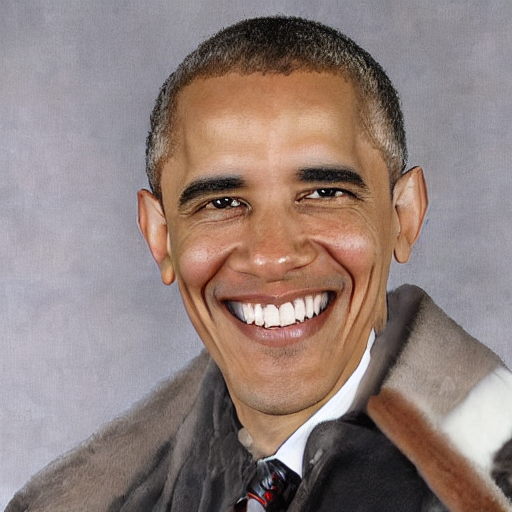

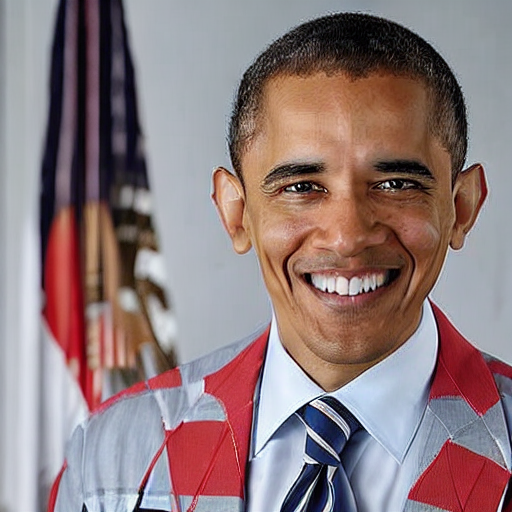

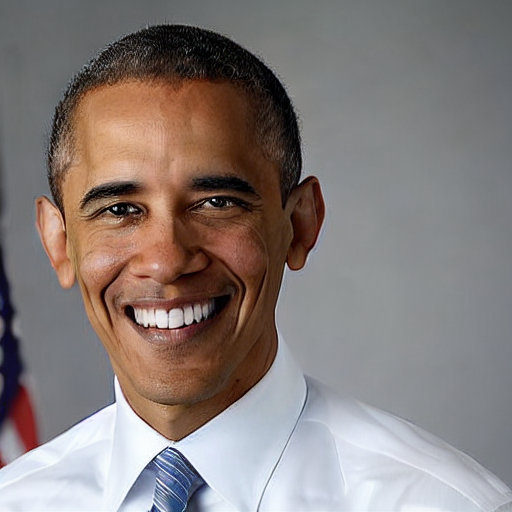

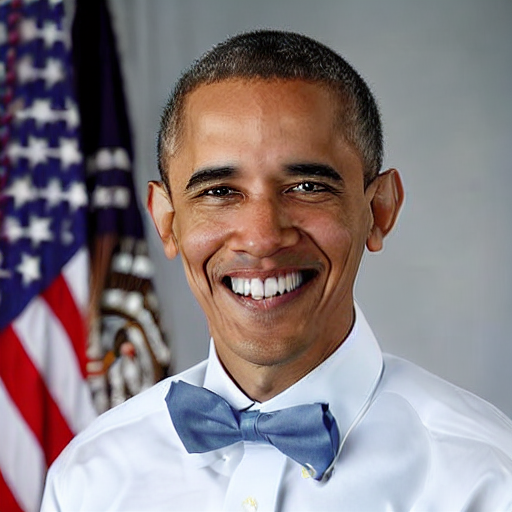

In [4]:
#@title Run for generating images.

alpha = 0.9 #@param {type:"number"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 3 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

edit_embeddings = alpha*target_embeddings + (1-alpha)*optimized_embeddings

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        text_embeddings=edit_embeddings,
        height=height,
        width=width,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [ ]:
#@markdown Run Gradio UI for generating images.
import gradio as gr

def inference(alpha, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        edit_embeddings = alpha*target_embeddings + (1-alpha)*optimized_embeddings
        return pipe(
                text_embeddings=edit_embeddings, height=int(height), width=int(width),
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            alpha = gr.Number(label="Prompt", value=0.9)
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=3)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=50)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[alpha, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)